In [33]:
%load_ext autoreload 
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [34]:
import sys
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from catboost import CatBoostClassifier
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as imbpipeline
from lightgbm import LGBMClassifier
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import (AdaBoostClassifier, GradientBoostingClassifier,
                              RandomForestClassifier)
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, f1_score, precision_score,
                             recall_score, roc_auc_score)
from sklearn.model_selection import KFold, StratifiedKFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (OneHotEncoder, PowerTransformer,
                                   StandardScaler)
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

warnings.filterwarnings("ignore")

# import src/preprocessing.py script
sys.path.append("../src")
from preprocessing import (apply_basic_data_preprocessing,
                           apply_data_preprocessing, create_new_features,
                           drop_columns, one_hot_encode)

In [3]:
data_path = "../data/raw/credit_card_default.csv"
df_raw = pd.read_csv(data_path)
df = df_raw.copy()

In [4]:
target = "default_next_month"
random_state = 42

## Apply basic data preprocessing

1. Drop ID column
2. Rename columns for clarity
3. Remap labels for clarity
3. Apply one hot encoding (N-1)
4. No scaling or standardisation
5. No feature engineering
6. No SMOTE resampling

Apply default random forest with stratified K-folds cross-validation.

In [5]:
df = apply_basic_data_preprocessing(df)

In [6]:
df.head()

,credit_limit,gender,education_level,marital_status,age,repay_status_sep,repay_status_aug,repay_status_jul,repay_status_jun,repay_status_may,...,bill_amt_jun,bill_amt_may,bill_amt_apr,pay_amt_sep,pay_amt_aug,pay_amt_jul,pay_amt_jun,pay_amt_may,pay_amt_apr,default_next_month
0,20000.0,female,university,married,24,delay_2_mnths,delay_2_mnths,-1_paid_in_full,-1_paid_in_full,-2_no_consumption,...,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,120000.0,female,university,single,26,-1_paid_in_full,delay_2_mnths,0_paid_minimum,0_paid_minimum,0_paid_minimum,...,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
2,90000.0,female,university,single,34,0_paid_minimum,0_paid_minimum,0_paid_minimum,0_paid_minimum,0_paid_minimum,...,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
3,50000.0,female,university,married,37,0_paid_minimum,0_paid_minimum,0_paid_minimum,0_paid_minimum,0_paid_minimum,...,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
4,50000.0,male,university,married,57,-1_paid_in_full,0_paid_minimum,-1_paid_in_full,0_paid_minimum,0_paid_minimum,...,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0


In [7]:
def one_hot_encode(df):
    df = df.copy()
    cat_cols = df.select_dtypes(include=["object", "category"]).columns

    ohe = OneHotEncoder(drop="first")
    encoded_data = ohe.fit_transform(df[cat_cols]).toarray()
    new_cols = ohe.get_feature_names_out(cat_cols)
    encoded_df = pd.DataFrame(encoded_data, columns=new_cols)
    df = pd.concat([df.drop(cat_cols, axis=1), encoded_df], axis=1)

    return df

In [8]:
df = one_hot_encode(df)

In [9]:
def train_evaluate_model_basic(
    model,
    df=df,
    target=target,
    n_splits=5,
    random_state=0,
):
    # Separating features and target
    X = df.drop(columns=[target])
    y = df[target]

    # Initialize StratifiedKFold
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)

    # Lists to store metrics for each fold
    f1_scores = []
    roc_auc_scores = []
    accuracy_scores = []
    precision_scores = []
    recall_scores = []

    # Perform k-fold cross-validation
    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        # Train the model
        model.fit(X_train, y_train)

        # Make predictions on the test set
        y_pred = model.predict(X_test)
        y_pred_proba = model.predict_proba(X_test)[:, 1]

        # Calculate metrics and append to lists
        f1_scores.append(f1_score(y_test, y_pred))
        roc_auc_scores.append(roc_auc_score(y_test, y_pred_proba))
        accuracy_scores.append(accuracy_score(y_test, y_pred))
        precision_scores.append(precision_score(y_test, y_pred))
        recall_scores.append(recall_score(y_test, y_pred))

    # Calculate the average of each metric across all folds
    avg_metrics = {
        "Mean F1 Score": round(np.mean(f1_scores), 4),
        "Mean ROC-AUC Score": round(np.mean(roc_auc_scores), 4),
        "Mean Accuracy": round(np.mean(accuracy_scores), 4),
        "Mean Precision": round(np.mean(precision_scores), 4),
        "Mean Recall": round(np.mean(recall_scores), 4),
    }

    return avg_metrics

In [10]:
decision_tree = DecisionTreeClassifier(random_state=random_state)

train_evaluate_model_basic(model=decision_tree)

{'Mean F1 Score': 0.3964,
 'Mean ROC-AUC Score': 0.6121,
 'Mean Accuracy': 0.725,
 'Mean Precision': 0.3852,
 'Mean Recall': 0.4082}

## Test multiple tree-based models

In [11]:
# classifier list for the normal training set
clf_list = [
    DecisionTreeClassifier(max_depth=3, class_weight="balanced"),
    RandomForestClassifier(n_estimators=100, class_weight="balanced"),
    AdaBoostClassifier(
        DecisionTreeClassifier(max_depth=3, class_weight="balanced"), n_estimators=100
    ),
    GradientBoostingClassifier(),
    XGBClassifier(verbosity=0),
    LGBMClassifier(verbosity=-1),
    CatBoostClassifier(verbose=0)
]

In [12]:
%%time
for clf in clf_list:
    print(clf)
    print(train_evaluate_model_basic(model=clf))
    print()

DecisionTreeClassifier(class_weight='balanced', max_depth=3)
{'Mean F1 Score': 0.4954, 'Mean ROC-AUC Score': 0.7266, 'Mean Accuracy': 0.8045, 'Mean Precision': 0.5773, 'Mean Recall': 0.4338}

RandomForestClassifier(class_weight='balanced')
{'Mean F1 Score': 0.4554, 'Mean ROC-AUC Score': 0.765, 'Mean Accuracy': 0.8167, 'Mean Precision': 0.6644, 'Mean Recall': 0.3464}

AdaBoostClassifier(estimator=DecisionTreeClassifier(class_weight='balanced',
                                                    max_depth=3),
                   n_estimators=100)
{'Mean F1 Score': 0.5034, 'Mean ROC-AUC Score': 0.7413, 'Mean Accuracy': 0.7264, 'Mean Precision': 0.4207, 'Mean Recall': 0.6269}

GradientBoostingClassifier()
{'Mean F1 Score': 0.4696, 'Mean ROC-AUC Score': 0.7818, 'Mean Accuracy': 0.8203, 'Mean Precision': 0.6765, 'Mean Recall': 0.3597}

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, 

## Apply feature engineering

In [13]:
df2 = df_raw.copy()
df2 = apply_data_preprocessing(df2)
df2 = create_new_features(df2)
#df2 = drop_columns(df)

df2.head()

,id,credit_limit,gender,education_level,marital_status,age,repay_status_sep,repay_status_aug,repay_status_jul,repay_status_jun,...,repay_label_jul,repay_label_jun,repay_label_may,repay_label_apr,age_group,count_of_delayed_payments,marital_gender,education_gender,education_marital,education_marital_gender
0,1,20000.0,female,university,married,24,delay_2_mnths,delay_2_mnths,-1_paid_in_full,-1_paid_in_full,...,-1,-1,-2,-2,21-25,2,married_female,university_female,university_married,university_married_female
1,2,120000.0,female,university,single,26,-1_paid_in_full,delay_2_mnths,0_paid_minimum,0_paid_minimum,...,0,0,0,2,26-35,2,single_female,university_female,university_single,university_single_female
2,3,90000.0,female,university,single,34,0_paid_minimum,0_paid_minimum,0_paid_minimum,0_paid_minimum,...,0,0,0,0,26-35,0,single_female,university_female,university_single,university_single_female
3,4,50000.0,female,university,married,37,0_paid_minimum,0_paid_minimum,0_paid_minimum,0_paid_minimum,...,0,0,0,0,36-50,0,married_female,university_female,university_married,university_married_female
4,5,50000.0,male,university,married,57,-1_paid_in_full,0_paid_minimum,-1_paid_in_full,0_paid_minimum,...,-1,0,0,0,51-65,0,married_male,university_male,university_married,university_married_male


In [14]:
columns_to_drop = [
    "id",
    "repay_label_sep",
    "repay_label_aug",
    "repay_label_jul",
    "repay_label_jun",
    "repay_label_may",
    "repay_label_apr",
]
df2 = df2.drop(columns=columns_to_drop)

In [15]:
df2 = one_hot_encode(df2)

In [16]:
df2.shape

(30000, 147)

In [17]:
for clf in clf_list:
    print(clf)
    print(train_evaluate_model_basic(model=clf, df=df2))
    print()

DecisionTreeClassifier(class_weight='balanced', max_depth=3)
{'Mean F1 Score': 0.4954, 'Mean ROC-AUC Score': 0.7265, 'Mean Accuracy': 0.8045, 'Mean Precision': 0.5773, 'Mean Recall': 0.4338}

RandomForestClassifier(class_weight='balanced')
{'Mean F1 Score': 0.4551, 'Mean ROC-AUC Score': 0.7646, 'Mean Accuracy': 0.8154, 'Mean Precision': 0.6558, 'Mean Recall': 0.3486}

AdaBoostClassifier(estimator=DecisionTreeClassifier(class_weight='balanced',
                                                    max_depth=3),
                   n_estimators=100)
{'Mean F1 Score': 0.5011, 'Mean ROC-AUC Score': 0.7382, 'Mean Accuracy': 0.7279, 'Mean Precision': 0.4215, 'Mean Recall': 0.6183}

GradientBoostingClassifier()
{'Mean F1 Score': 0.4683, 'Mean ROC-AUC Score': 0.7819, 'Mean Accuracy': 0.8201, 'Mean Precision': 0.6761, 'Mean Recall': 0.3583}

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None,

## Apply SMOTE

In [18]:
%%time
def train_evaluate_model_SMOTE(
    model,
    df=df,
    target=target,
    n_splits=5,
    random_state=0,
):
    # Separating features and target
    X = df.drop(columns=[target])
    y = df[target]

    kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)

    # Lists to store metrics for each fold
    f1_scores = []
    roc_auc_scores = []
    accuracy_scores = []
    precision_scores = []
    recall_scores = []

    for fold, (train_index, test_index) in enumerate(kf.split(X, y), 1):
        X_train = X.iloc[train_index]
        y_train = y.iloc[train_index]
        X_test = X.iloc[test_index]
        y_test = y.iloc[test_index]

        # Apply resampling
        sm = SMOTE()
        X_train_oversampled, y_train_oversampled = sm.fit_resample(X_train, y_train)

        # Fit model
        model.fit(X_train_oversampled, y_train_oversampled)

        # Predict on test set
        y_pred = model.predict(X_test)

        # print(f"For fold {fold}:")
        # print(f"f-score: {f1_score(y_test, y_pred)}")
        # print(f"Accuracy: {model.score(X_test, y_test)}")

        # Calculate metrics and append to lists
        f1_scores.append(f1_score(y_test, y_pred))
        roc_auc_scores.append(roc_auc_score(y_test, y_pred))
        accuracy_scores.append(accuracy_score(y_test, y_pred))
        precision_scores.append(precision_score(y_test, y_pred))
        recall_scores.append(recall_score(y_test, y_pred))

    avg_metrics = {
        "Mean F1 Score": round(np.mean(f1_scores), 4),
        "Mean ROC-AUC Score": round(np.mean(roc_auc_scores), 4),
        "Mean Accuracy": round(np.mean(accuracy_scores), 4),
        "Mean Precision": round(np.mean(precision_scores), 4),
        "Mean Recall": round(np.mean(recall_scores), 4),
    }

    return avg_metrics

CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 3.81 µs


In [19]:
for clf in clf_list:
    print(clf)
    print(train_evaluate_model_SMOTE(model=clf, df=df2))
    print()

DecisionTreeClassifier(class_weight='balanced', max_depth=3)


{'Mean F1 Score': 0.4909, 'Mean ROC-AUC Score': 0.6744, 'Mean Accuracy': 0.7647, 'Mean Precision': 0.4795, 'Mean Recall': 0.5124}

RandomForestClassifier(class_weight='balanced')
{'Mean F1 Score': 0.4741, 'Mean ROC-AUC Score': 0.6584, 'Mean Accuracy': 0.8134, 'Mean Precision': 0.6295, 'Mean Recall': 0.3804}

AdaBoostClassifier(estimator=DecisionTreeClassifier(class_weight='balanced',
                                                    max_depth=3),
                   n_estimators=100)
{'Mean F1 Score': 0.4496, 'Mean ROC-AUC Score': 0.6458, 'Mean Accuracy': 0.8001, 'Mean Precision': 0.5749, 'Mean Recall': 0.3692}

GradientBoostingClassifier()
{'Mean F1 Score': 0.4735, 'Mean ROC-AUC Score': 0.6575, 'Mean Accuracy': 0.8201, 'Mean Precision': 0.6709, 'Mean Recall': 0.3659}

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enabl

## Evalulate best model with optimised hyperparameters

In [20]:
param_dict = {
    #"n_jobs": -1,
    "learning_rate": 0.2,
    "depth": 9,
    "rsm": 0.5152171870988894,
    "loss_function": "Logloss",
    "eval_metric": "F1",
    "l2_leaf_reg": 9.109583514818459,
    "random_strength": 3.6113219270123293,
    "min_data_in_leaf": 73,
    "num_boost_round": 1000,
    "early_stopping_rounds": 50,
    "verbose": 0
    #"explain_level": 0,
}

catboost_opt = CatBoostClassifier(**param_dict)

In [21]:
train_evaluate_model_basic(catboost_opt, df=df2)

{'Mean F1 Score': 0.4655,
 'Mean ROC-AUC Score': 0.7515,
 'Mean Accuracy': 0.8085,
 'Mean Precision': 0.6081,
 'Mean Recall': 0.377}

In [22]:
train_evaluate_model_SMOTE(catboost_opt, df=df2)

{'Mean F1 Score': 0.4689,
 'Mean ROC-AUC Score': 0.656,
 'Mean Accuracy': 0.807,
 'Mean Precision': 0.5988,
 'Mean Recall': 0.3853}

### Get feature importance

In [23]:
X = df2.drop(columns=[target])
y = df2[target]

In [24]:
X.head()

,credit_limit,age,bill_amt_sep,bill_amt_aug,bill_amt_jul,bill_amt_jun,bill_amt_may,bill_amt_apr,pay_amt_sep,pay_amt_aug,...,education_marital_gender_university_others_female,education_marital_gender_university_others_male,education_marital_gender_university_single_female,education_marital_gender_university_single_male,education_marital_gender_unknown_married_female,education_marital_gender_unknown_married_male,education_marital_gender_unknown_others_female,education_marital_gender_unknown_others_male,education_marital_gender_unknown_single_female,education_marital_gender_unknown_single_male
0,20000.0,24,3913.0,3102.0,689.0,0.0,0.0,0.0,0.0,689.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,120000.0,26,2682.0,1725.0,2682.0,3272.0,3455.0,3261.0,0.0,1000.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,90000.0,34,29239.0,14027.0,13559.0,14331.0,14948.0,15549.0,1518.0,1500.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,50000.0,37,46990.0,48233.0,49291.0,28314.0,28959.0,29547.0,2000.0,2019.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,50000.0,57,8617.0,5670.0,35835.0,20940.0,19146.0,19131.0,2000.0,36681.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [25]:
catboost_opt.fit(X, y)

In [26]:
feature_importances = catboost_opt.feature_importances_

In [27]:
feature_names = X.columns
importance_df = pd.DataFrame(
    {"Feature": feature_names, "Importance": feature_importances}
)
importance_df = importance_df.sort_values(by="Importance", ascending=False)

In [28]:
importance_df

,Feature,Importance
0,credit_limit,7.881428
1,age,6.925934
9,pay_amt_aug,6.455951
13,pay_amt_apr,6.321016
10,pay_amt_jul,6.187334
...,...,...
60,repay_status_jun_delay_8_mnths,0.000024
109,education_marital_others_others,0.000022
69,repay_status_may_delay_8_mnths,0.000003
130,education_marital_gender_others_others_female,0.000001


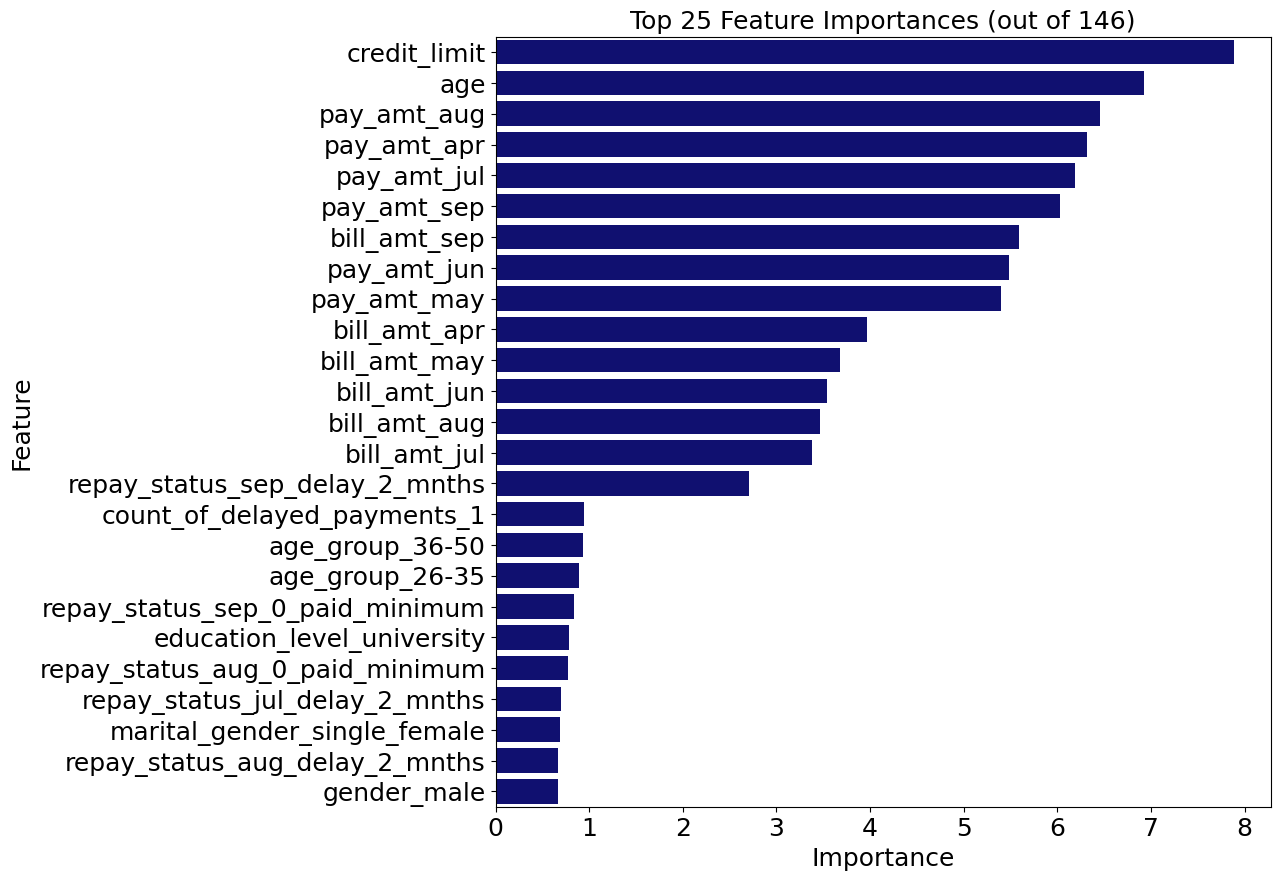

In [44]:
plt.figure(figsize=(10, 10))
sns.barplot(x="Importance", y="Feature", data=importance_df.head(25), color='navy')

plt.title("Top 25 Feature Importances (out of 146)", fontsize=18)
plt.xlabel("Importance", fontsize=18)
plt.ylabel("Feature", fontsize=18)

plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

plt.show()